In [954]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [956]:
# all the unique station in the provided dataset
unique_stations = ['FPZ_04A', 'FSB_126', 'FSB_079', 'FPZ_06A', 'FEX_004', 'FSB_078',
       'FSB_097D', 'FSB_130D', 'FSB_095DR']
finder = {}
for index, val in enumerate(unique_stations):
    finder[val]= index

finder

{'FPZ_04A': 0,
 'FSB_126': 1,
 'FSB_079': 2,
 'FPZ_06A': 3,
 'FEX_004': 4,
 'FSB_078': 5,
 'FSB_097D': 6,
 'FSB_130D': 7,
 'FSB_095DR': 8}

In [958]:
index = 4
df = pd.read_csv(f"./data/{unique_stations[index]}.csv")
df = df.dropna()
print(df.size)

154686


In [960]:
min_date = df["Date Time"].min()
min_date

1667946840000.0

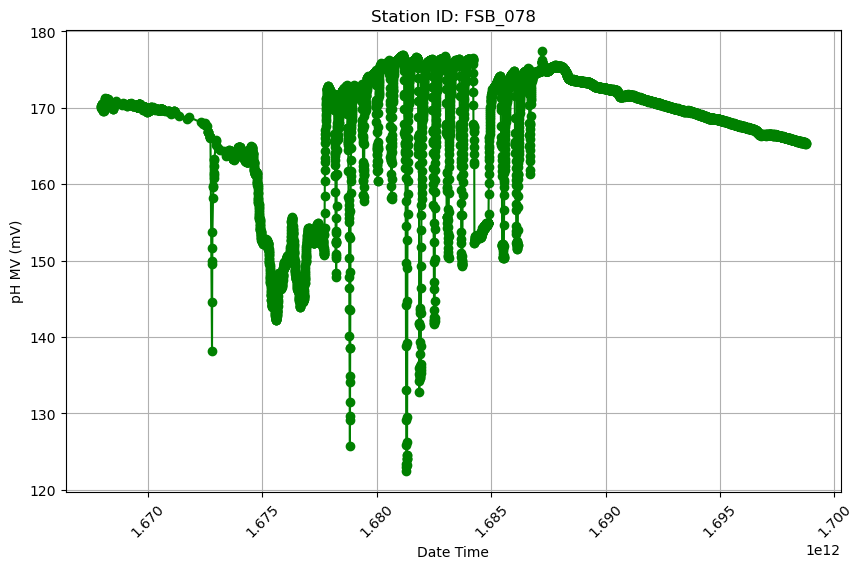

In [962]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date Time'], df['pH MV (mV)'], marker='o', color ="green")
plt.title(f'Station ID: FSB_078')
plt.xlabel('Date Time')
plt.ylabel('pH MV (mV)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [964]:
num_of_months = 1
temp_months = num_of_months * 30 * 24 * 60 * 60 * 1000
first_temp_months = df[df["Date Time"] <= temp_months + min_date]
first_temp_months.size

6006

In [966]:
later_temp_months = df[df["Date Time"] > temp_months + min_date]
later_temp_months.size

148680

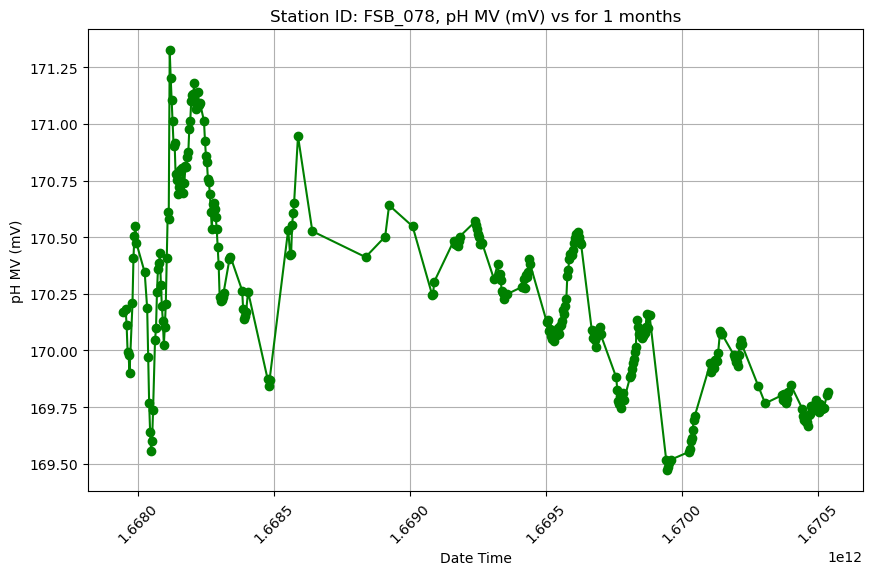

In [968]:
plt.figure(figsize=(10, 6))
plt.plot(first_temp_months['Date Time'], first_temp_months['pH MV (mV)'], marker='o', color ="green")
plt.title(f'Station ID: FSB_078, pH MV (mV) vs for {num_of_months} months')
plt.xlabel('Date Time')
plt.ylabel('pH MV (mV)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [970]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [972]:
training_data_X = first_temp_months.drop(columns = ["station_id","Date Time","pH MV (mV)", "easting", "northing"])
training_data_y = first_temp_months["pH MV (mV)"].values.reshape(-1,1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

training_data_X = scaler_X.fit_transform(training_data_X)
training_data_y = scaler_y.fit_transform(training_data_y)

In [974]:
test_data_X = later_temp_months.drop(columns = ["station_id","Date Time","pH MV (mV)","easting", "northing"])
test_data_y = later_temp_months["pH MV (mV)"].values.reshape(-1,1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

test_data_X = scaler_X.fit_transform(test_data_X)
test_data_y = scaler_y.fit_transform(test_data_y)

In [976]:
X_train_tensor = torch.tensor(training_data_X, dtype=torch.float32)
y_train_tensor = torch.tensor(training_data_y, dtype=torch.float32)
print(f"shape of training X and y are {X_train_tensor.shape}, {y_train_tensor.shape}")

shape of training X and y are torch.Size([286, 16]), torch.Size([286, 1])


In [978]:
X_test_tensor = torch.tensor(test_data_X, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data_y, dtype=torch.float32)
print(f"shape of test X and y are {X_test_tensor.shape}, {y_test_tensor.shape}")

shape of test X and y are torch.Size([7080, 16]), torch.Size([7080, 1])


In [980]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [982]:
input_dim = training_data_X.shape[1]
output_dim = training_data_y.shape[1]

model = SimpleNN(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [984]:
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0540
Epoch [20/100], Loss: 0.0063
Epoch [30/100], Loss: 0.0032
Epoch [40/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0007
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0002


In [986]:
model.eval()  
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
y_test_pred.shape

torch.Size([7080, 1])

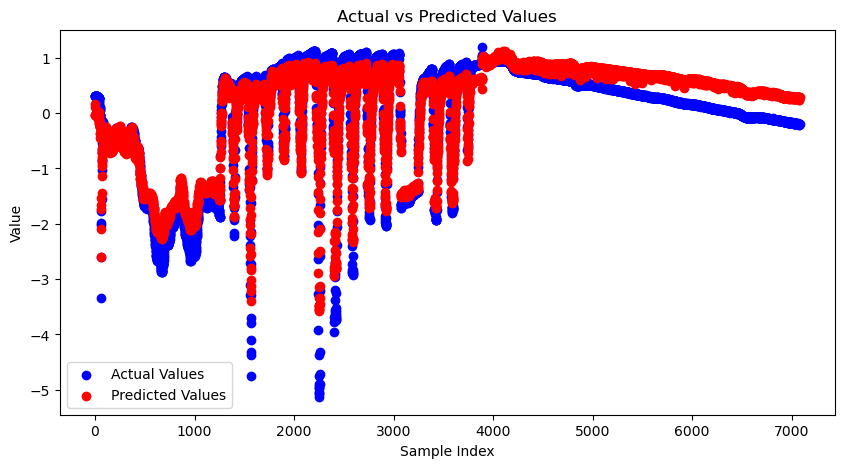

In [990]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_tensor)), y_test_tensor, color='blue', label='Actual Values')
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [992]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 6),  # Input layer with 10 hidden units
            nn.ReLU(),
            nn.Linear(6, 3),  # Hidden layer with 16 hidden units
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, input_dim)

         # nn.Sigmoi# Output layer with same dimension as input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [994]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [996]:
model = Autoencoder(input_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [998]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.9863
Epoch [20/100], Loss: 0.6929
Epoch [30/100], Loss: 0.4411
Epoch [40/100], Loss: 0.4754
Epoch [50/100], Loss: 0.4027
Epoch [60/100], Loss: 0.4024
Epoch [70/100], Loss: 0.2641
Epoch [80/100], Loss: 0.2874
Epoch [90/100], Loss: 0.2832
Epoch [100/100], Loss: 0.3016


In [1015]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed_data) ** 2, axis=1).numpy()
reconstruction_error

array([1.7594032 , 1.7404448 , 1.9411501 , ..., 0.8684865 , 0.86381704,
       0.7579429 ], dtype=float32)

In [1017]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)


In [1023]:
anomalies = reconstruction_error > threshold


In [1025]:
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 564
